In [1]:
import os
import json
from copy import deepcopy
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, balanced_accuracy_score, roc_curve, auc


In [2]:
#;atplotlib con LaTex
from matplotlib import rc
rc('font', **{'family':'serif','serif':'Computer Modern'})
rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}') #Cargar paquetes de latex para usar sus funciones

# Process Experiment Results

This notebook generates the metrics and grpahs presented in the publication.

In [3]:
embeddings_metadata = {
    "bge-reranker-v2-m3" : {
        "params" : 0.568,
        "instruction_applied" : False,
        "reranker" : True,
        "a-vert_enhance" : True,
        "huggingface_name" : "BAAI/bge-reranker-v2-m3"
    },
    "bge-reranker-v2-m3---no-enhance" : {
        "params" : 0.568,
        "instruction_applied" : False,
        "reranker" : True,
        "a-vert_enhance" : False,
        "huggingface_name" : "BAAI/bge-reranker-v2-m3"
    },
    "gte-modernbert-base" : {
        "params" : 0.150,
        "instruction_applied" : False,
        "reranker" : False,
        "a-vert_enhance" : True,
        "huggingface_name" : "Alibaba-NLP/gte-modernbert-base"
    },
    "gte-modernbert-base---no-enhance" : {
        "params" : 0.150,
        "instruction_applied" : False,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "Alibaba-NLP/gte-modernbert-base"
    },
    "gte-reranker-modernbert-base" : {
        "params" : 0.150,
        "instruction_applied" : False,
        "reranker" : True,
        "a-vert_enhance" : True,
        "huggingface_name" : "Alibaba-NLP/gte-reranker-modernbert-base"
    },
    "gte-reranker-modernbert-base---no-enhance" : {
        "params" : 0.150,
        "instruction_applied" : False,
        "reranker" : True,
        "a-vert_enhance" : False,
        "huggingface_name" : "Alibaba-NLP/gte-reranker-modernbert-base"
    },
    "jina-reranker-v2-base-multilingual" : {
        "params" : 0.278,
        "instruction_applied" : False,
        "reranker" : True,
        "a-vert_enhance" : True,
        "huggingface_name" : "jinaai/jina-reranker-v2-base-multilingual"
    },
    "jina-reranker-v2-base-multilingual---no-enhance" : {
        "params" : 0.278,
        "instruction_applied" : False,
        "reranker" : True,
        "a-vert_enhance" : False,
        "huggingface_name" : "jinaai/jina-reranker-v2-base-multilingual"
    },
    "multilingual-e5-large-instruct" : {
        "params" : 0.560,
        "instruction_applied" : True,
        "reranker" : False,
        "a-vert_enhance" : True,
        "huggingface_name" : "intfloat/multilingual-e5-large-instruct"
    },
    "multilingual-e5-large-instruct---no-enhance" : {
        "params" : 0.560,
        "instruction_applied" : True,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "intfloat/multilingual-e5-large-instruct"
    },
    "multilingual-e5-large-instruct---no-instruct,no-enhance" : {
        "params" : 0.560,
        "instruction_applied" : False,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "intfloat/multilingual-e5-large-instruct"
    },
    "Qwen3-Embedding-0.6B" : {
        "params" : 0.6,
        "instruction_applied" : True,
        "reranker" : False,
        "a-vert_enhance" : True,
        "huggingface_name" : "Qwen/Qwen3-Embedding-0.6B"
    },
    "Qwen3-Embedding-0.6B---no-enhance" : {
        "params" : 0.6,
        "instruction_applied" : True,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "Qwen/Qwen3-Embedding-0.6B"
    },
    "Qwen3-Embedding-0.6B---no-instruct,no-enhance" : {
        "params" : 0.6,
        "instruction_applied" : False,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "Qwen/Qwen3-Embedding-0.6B"
    },
    "Qwen3-Embedding-4B" : {
        "params" : 4,
        "instruction_applied" : True,
        "reranker" : False,
        "a-vert_enhance" : True,
        "huggingface_name" : "Qwen/Qwen3-Embedding-4B"
    },
    "Qwen3-Embedding-4B---no-enhance" : {
        "params" : 4,
        "instruction_applied" : True,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "Qwen/Qwen3-Embedding-4B"
    },
    "Qwen3-Embedding-4B---no-instruct,no-enhance" : {
        "params" : 4,
        "instruction_applied" : False,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "Qwen/Qwen3-Embedding-4B"
    },
    "Qwen3-Reranker-0.6B-seq-cls" : {
        "params" : 0.6,
        "instruction_applied" : True,
        "reranker" : True,
        "a-vert_enhance" : True,
        "huggingface_name" : "tomaarsen/Qwen3-Reranker-0.6B-seq-cls"
    },
    "Qwen3-Reranker-0.6B-seq-cls---no-enhance" : {
        "params" : 0.6,
        "instruction_applied" : True,
        "reranker" : True,
        "a-vert_enhance" : False,
        "huggingface_name" : "tomaarsen/Qwen3-Reranker-0.6B-seq-cls"
    },
    "Qwen3-Reranker-4B-seq-cls" : {
        "params" : 4,
        "instruction_applied" : True,
        "reranker" : True,
        "a-vert_enhance" : True,
        "huggingface_name" : "tomaarsen/Qwen3-Reranker-4B-seq-cls"
    },
    "Qwen3-Reranker-4B-seq-cls---no-enhance" : {
        "params" : 4,
        "instruction_applied" : True,
        "reranker" : True,
        "a-vert_enhance" : False,
        "huggingface_name" : "tomaarsen/Qwen3-Reranker-4B-seq-cls"
    },
    "Qwen3-Reranker-8B-seq-cls" : {
        "params" : 8,
        "instruction_applied" : True,
        "reranker" : True,
        "a-vert_enhance" : True,
        "huggingface_name" : "tomaarsen/Qwen3-Reranker-8B-seq-cls"
    },
    "Qwen3-Reranker-8B-seq-cls---no-enhance" : {
        "params" : 8,
        "instruction_applied" : True,
        "reranker" : True,
        "a-vert_enhance" : False,
        "huggingface_name" : "tomaarsen/Qwen3-Reranker-8B-seq-cls"
    },
    "Qwen3-Embedding-8B" : {
        "params" : 8,
        "instruction_applied" : True,
        "reranker" : False,
        "a-vert_enhance" : True,
        "huggingface_name" : "Qwen/Qwen3-Embedding-8B"
    },
    "Qwen3-Embedding-8B---no-enhance" : {
        "params" : 8,
        "instruction_applied" : True,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "Qwen/Qwen3-Embedding-8B"
    },
    "Qwen3-Embedding-8B---no-instruct,no-enhance" : {
        "params" : 8,
        "instruction_applied" : False,
        "reranker" : False,
        "a-vert_enhance" : False,
        "huggingface_name" : "Qwen/Qwen3-Embedding-8B"
    },
}




In [4]:
renaming_rank_model_map = {
    "Qwen3-Reranker-8B-seq-cls":"Qwen3-Reranker-8B",
    "Qwen3-Reranker-4B-seq-cls":"Qwen3-Reranker-4B",
    "Qwen3-Reranker-0.6B-seq-cls":"Qwen3-Reranker-0.6B",
    "bge-reranker-v2-m3":"bge-reranker-v2-m3",
    "jina-reranker-v2-base-multilingual":"jina-reranker-v2-base-Multilingual",
    "gte-reranker-modernbert-base":"gte-reranker-modernbert-Base",
    "Qwen3-Embedding-8B":"Qwen3-Embedding-8B",
    "Qwen3-Embedding-4B":"Qwen3-Embedding-4B",
    "Qwen3-Embedding-0.6B":"Qwen3-Embedding-0.6B",
    "multilingual-e5-large-instruct":"multilingual-e5-large-instruct",
    "gte-modernbert-base":"gte-modernbert-base"
}

rename_llm_model_map = {
    'Meta-Llama-3-3-70B-Instruct-AWQ-INT4': 'Meta-Llama-3-3-70B-Instruct',
    'Qwen3-30B-A3B-GPTQ-Int4':'Qwen3-30B-A3B',
    'gpt-oss-20b': 'gpt-oss-20b'
}

In [5]:
DATA_PATH = f'../data/exploratory_analysis/'
TAGS_PATH = f'../data/implemented/'
BASELINES_PATH = f'../data/baselines/'

BEST_MODEL = "Qwen3-Reranker-4B-seq-cls"
BEST_IS_INSTRUCTED = True
BEST_IS_RERANKER = True
BEST_IS_ENHANCED = True

SAVE_FIGURES = True
OUTPUT_PATH_FIGURES = './output'
label_size = 20
title_size = 36
legend_size = 18

In [6]:
if SAVE_FIGURES:
    if not os.path.exists(OUTPUT_PATH_FIGURES):
        os.makedirs(OUTPUT_PATH_FIGURES)

### Load human tags

In [7]:
tags_rows = list()
for lm_dir in os.listdir(TAGS_PATH):
    model_path = os.path.join(TAGS_PATH, lm_dir)
    if not os.path.isdir(model_path):
        continue
    # The file should be here
    tags_path = os.path.join(TAGS_PATH, lm_dir, "human_labels.jsonl")
    # Read all lines
    with open(tags_path, 'r') as f:
        for i, line in enumerate(f):
            obj = json.loads(line)
            tags_rows.append(
                [
                    lm_dir,
                    obj["dataset_task"],
                    obj["line"],
                    obj["label"]=="Correct",
                ]
            )
tags_df = pd.DataFrame(tags_rows, columns=["language_model", "dataset_task", "prompt_idx", "human_tag"])
print(f"Read {len(tags_df)} tagged samples")

Read 14420 tagged samples


In [8]:
tags_df.head()

,language_model,dataset_task,prompt_idx,human_tag
0,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,10,False
1,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,11,False
2,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,12,True
3,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,13,True
4,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,14,False


### Load exploratory tests

In [9]:
data_rows = list()
# For each embedding model tested

for emb_model_dir in tqdm(os.listdir(DATA_PATH), total=len(os.listdir(DATA_PATH))):
    emb_path = os.path.join(DATA_PATH, emb_model_dir)
    if not os.path.isdir(emb_path):
        continue
    # For each LM tested
    for lm_dir in os.listdir(emb_path):
        # For each results file
        model_path = os.path.join(emb_path, lm_dir)
        for result_file in os.listdir(model_path):
            if ".jsonl" not in result_file:
                continue
            # Read all lines
            with open(os.path.join(model_path, result_file), 'r') as f:
                for i, line in enumerate(f):
                    obj = json.loads(line)
                    # Get model metadata
                    model_metadata = embeddings_metadata[emb_model_dir]
                    # Add entry
                    data_rows.append(
                        [
                            model_metadata["huggingface_name"].split("/")[-1],
                            model_metadata["params"],
                            model_metadata["instruction_applied"],
                            model_metadata["reranker"],
                            model_metadata["a-vert_enhance"],
                            lm_dir,
                            int(np.ceil(len(obj["resps"][0][0].split(" "))*0.75)),
                            int(np.ceil(len(obj["arguments"]["gen_args_0"]["arg_0"][0].split(" "))*0.75)),                            
                            result_file.split('_2025')[0].split('samples_')[-1],
                            obj["doc_id"],
                            obj["a-vert_match"],
                            obj["a-vert_correct_score"],
                            obj["a-vert_wrong_score"],
                            obj["semscore"],
                        ]
                    )
                    
data_df = pd.DataFrame(data_rows, columns=["embedding_model", 
                                           "params_billons",
                                           "instruction_applied",
                                           "reranker",
                                           "enhance",
                                           "language_model", 
                                           "aprox_output_tokens", 
                                           "aprox_input_tokens",                                            
                                           "dataset_task", 
                                           "prompt_idx", 
                                           "a-vert_match", 
                                           "a-vert_correct_score", 
                                           "a-vert_wrong_score", 
                                           "semscore"])
print(f"Read {len(data_df)} experiment samples")

100%|██████████| 26/26 [00:19<00:00,  1.33it/s]


Read 709800 experiment samples


In [10]:
data_df.head()

,embedding_model,params_billons,instruction_applied,reranker,enhance,language_model,aprox_output_tokens,aprox_input_tokens,dataset_task,prompt_idx,a-vert_match,a-vert_correct_score,a-vert_wrong_score,semscore
0,gte-reranker-modernbert-base,0.15,False,True,False,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,38,175,mmlu_professional_law_chat_generative,0,False,0.496184,0.503816,0.0
1,gte-reranker-modernbert-base,0.15,False,True,False,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,117,191,mmlu_professional_law_chat_generative,1,False,0.491913,0.508087,0.0
2,gte-reranker-modernbert-base,0.15,False,True,False,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,37,114,mmlu_professional_law_chat_generative,2,True,0.509055,0.490945,0.0
3,gte-reranker-modernbert-base,0.15,False,True,False,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,203,111,mmlu_professional_law_chat_generative,3,True,0.511919,0.488081,0.0
4,gte-reranker-modernbert-base,0.15,False,True,False,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,187,122,mmlu_professional_law_chat_generative,4,False,0.492083,0.507917,0.0


### Combine experiment data with tags

In [11]:
merged_df = pd.merge(tags_df, data_df, on=['language_model', 'dataset_task', 'prompt_idx'])
# Create a column where the human tag and a-vert agree
merged_df["agree"] = merged_df["human_tag"]==merged_df["a-vert_match"]
print(f"Total number of test samples tagged: {len(merged_df)}\n")
print("Samples per LM:")
print(merged_df['language_model'].value_counts())
print("")
print("Samples per embedding/reranker:")
print(merged_df['embedding_model'].value_counts())


Total number of test samples tagged: 374920

Samples per LM:
language_model
Meta-Llama-3-3-70B-Instruct-AWQ-INT4    138320
Qwen3-30B-A3B-GPTQ-Int4                 118300
gpt-oss-20b                             118300
Name: count, dtype: int64

Samples per embedding/reranker:
embedding_model
Qwen3-Embedding-8B                    43260
Qwen3-Embedding-0.6B                  43260
multilingual-e5-large-instruct        43260
Qwen3-Embedding-4B                    43260
gte-reranker-modernbert-base          28840
gte-modernbert-base                   28840
Qwen3-Reranker-4B-seq-cls             28840
Qwen3-Reranker-0.6B-seq-cls           28840
jina-reranker-v2-base-multilingual    28840
Qwen3-Reranker-8B-seq-cls             28840
bge-reranker-v2-m3                    28840
Name: count, dtype: int64


In [12]:
def get_type(row):
    _,row=row
    if "babi" in row['dataset_task']:
        return "bAbI / open-ended"
    else:
        return "MMLU / multiple-choice"
    
merged_df['task_type'] = [get_type(a) for a in merged_df.iterrows()]

In [13]:
merged_df.head()

,language_model,dataset_task,prompt_idx,human_tag,embedding_model,params_billons,instruction_applied,reranker,enhance,aprox_output_tokens,aprox_input_tokens,a-vert_match,a-vert_correct_score,a-vert_wrong_score,semscore,agree,task_type
0,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,10,False,gte-reranker-modernbert-base,0.15,False,True,False,60,26,False,0.497225,0.502775,0.000000,True,bAbI / open-ended
1,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,10,False,Qwen3-Embedding-8B,8.00,False,False,False,60,26,False,0.466189,0.533811,0.000000,True,bAbI / open-ended
2,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,10,False,Qwen3-Embedding-0.6B,0.60,True,False,False,60,26,False,0.463396,0.536604,0.562774,True,bAbI / open-ended
3,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,10,False,Qwen3-Reranker-4B-seq-cls,4.00,True,True,True,60,26,False,0.173490,0.826510,0.562786,True,bAbI / open-ended
4,Meta-Llama-3-3-70B-Instruct-AWQ-INT4,babi-task_16-basic_induction,10,False,Qwen3-Embedding-0.6B,0.60,True,False,True,60,26,True,0.505671,0.494329,0.562774,False,bAbI / open-ended


In [14]:
def calculate_metrics(df):
    true_labels_binary = df['human_tag']
    predicted_labels_binary = df['a-vert_match']

    precision = precision_score(true_labels_binary, predicted_labels_binary)
    recall = recall_score(true_labels_binary, predicted_labels_binary)
    f1 = f1_score(true_labels_binary, predicted_labels_binary)
    specificity = recall_score(1-true_labels_binary, 1-predicted_labels_binary)
    balanced_accuracy = balanced_accuracy_score(true_labels_binary, predicted_labels_binary)

    return precision, recall, f1, specificity, balanced_accuracy

accurracy_compare_rows = list()
for model in list(merged_df['embedding_model'].unique()):
    for with_instrct in [True, False]:
        for with_enhance in [True, False]:
            for is_reranker in [True, False]:
                this_df = merged_df.loc[merged_df["embedding_model"] == model]
                this_df = this_df.loc[this_df["instruction_applied"] == with_instrct]
                if len(this_df) == 0 :
                    continue
                this_df = this_df.loc[this_df["enhance"] == with_enhance]
                if len(this_df) == 0 :
                    continue
                this_df = this_df.loc[this_df["reranker"] == is_reranker]
                if len(this_df) == 0 :
                    continue

                
                if with_instrct and with_enhance:
                    config_string = "instruction + enhance"
                elif with_instrct and not with_enhance:
                    config_string = "instruction"
                elif not with_instrct and with_enhance:
                    config_string = "enhance"
                else:
                    config_string = "base"
                
                # Compute
                precision, recall, f1, specificity, balanced_accuracy = calculate_metrics(this_df)
                # Track
                accurracy_compare_rows.append(
                    [
                        config_string,
                        model,
                        this_df["params_billons"].unique()[0],
                        with_instrct,
                        with_enhance,
                        is_reranker,
                        precision, 
                        recall, 
                        f1, 
                        specificity, 
                        balanced_accuracy
                    ]
                )
accurracy_compare_df = pd.DataFrame(accurracy_compare_rows, columns=[
                        "\nConfiguration:",
                        "Model:",
                        "params",
                        "with_instrct",
                        "with_enhance",
                        "is_reranker",
                        "precision", 
                        "recall", 
                        "f1", 
                        "specificity", 
                        "balanced_accuracy"
                    ])

# Plots

In [15]:
# # from accurracy_compare_df["Model:"] map the value into a new colum name "model_renamed" by taking the value from renaming_model_map
accurracy_compare_df["model_renamed"] = accurracy_compare_df["Model:"].map(renaming_rank_model_map)
accurracy_compare_df["ModelOriginal:"] = accurracy_compare_df["Model:"]
accurracy_compare_df["Model:"] = accurracy_compare_df["model_renamed"]

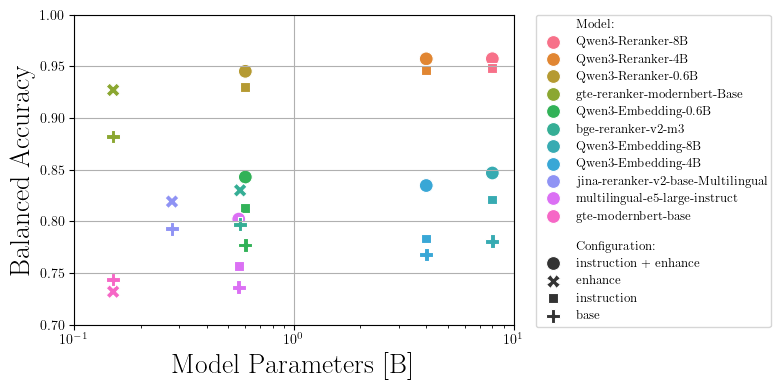

In [16]:
plt.figure(figsize=(8, 4))
scatter = sns.scatterplot(data=accurracy_compare_df, 
                          x="params", 
                          y="balanced_accuracy", 
                          hue='Model:', 
                          hue_order=[
                                renaming_rank_model_map["Qwen3-Reranker-8B-seq-cls"],
                                renaming_rank_model_map["Qwen3-Reranker-4B-seq-cls"],
                                renaming_rank_model_map["Qwen3-Reranker-0.6B-seq-cls"],
                                renaming_rank_model_map["gte-reranker-modernbert-base"],
                                renaming_rank_model_map["Qwen3-Embedding-0.6B"],
                                renaming_rank_model_map["bge-reranker-v2-m3"],
                                renaming_rank_model_map["Qwen3-Embedding-8B"],
                                renaming_rank_model_map["Qwen3-Embedding-4B"],
                                renaming_rank_model_map["jina-reranker-v2-base-multilingual"],
                                renaming_rank_model_map["multilingual-e5-large-instruct"],
                                renaming_rank_model_map["gte-modernbert-base"],
                                ],
                          style='\nConfiguration:', 
                          style_order=["instruction + enhance", "enhance", "instruction", "base"],
                          s=100)
plt.ylim(0.70,1.0)
plt.xlim(0.1,10.0)
plt.grid()
plt.xlabel("Model Parameters [B]", size=label_size)
plt.ylabel("Balanced Accuracy", size=label_size)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,prop={'size': 9})
plt.xscale('log')
plt.tight_layout()
if SAVE_FIGURES:
      plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, 'all_embeddings.png'))
      plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, 'all_embeddings.pdf'),dpi=300)
      plt.draw()
else:
      plt.title('Balanced accuracy of different Embedding and Reranker models', size=title_size)
plt.show()

In [17]:
accurracy_compare_df.sort_values("balanced_accuracy", ascending=False)

,\nConfiguration:,Model:,params,with_instrct,with_enhance,is_reranker,precision,recall,f1,specificity,balanced_accuracy,model_renamed,ModelOriginal:
22,instruction + enhance,Qwen3-Reranker-8B,8.000,True,True,True,0.984650,0.987300,0.985973,0.927668,0.957484,Qwen3-Reranker-8B,Qwen3-Reranker-8B-seq-cls
8,instruction + enhance,Qwen3-Reranker-4B,4.000,True,True,True,0.985416,0.983095,0.984254,0.931621,0.957358,Qwen3-Reranker-4B,Qwen3-Reranker-4B-seq-cls
23,instruction,Qwen3-Reranker-8B,8.000,True,False,True,0.983444,0.974180,0.978790,0.922925,0.948552,Qwen3-Reranker-8B,Qwen3-Reranker-8B-seq-cls
9,instruction,Qwen3-Reranker-4B,4.000,True,False,True,0.983852,0.968461,0.976096,0.925296,0.946879,Qwen3-Reranker-4B,Qwen3-Reranker-4B-seq-cls
18,instruction + enhance,Qwen3-Reranker-0.6B,0.600,True,True,True,0.984582,0.961396,0.972851,0.929249,0.945323,Qwen3-Reranker-0.6B,Qwen3-Reranker-0.6B-seq-cls
19,instruction,Qwen3-Reranker-0.6B,0.600,True,False,True,0.982552,0.937763,0.959635,0.921739,0.929751,Qwen3-Reranker-0.6B,Qwen3-Reranker-0.6B-seq-cls
0,enhance,gte-reranker-modernbert-Base,0.150,False,True,True,0.981271,0.938604,0.959464,0.915810,0.927207,gte-reranker-modernbert-Base,gte-reranker-modernbert-base
1,base,gte-reranker-modernbert-Base,0.150,False,False,True,0.977799,0.855677,0.912671,0.908696,0.882186,gte-reranker-modernbert-Base,gte-reranker-modernbert-base
2,instruction + enhance,Qwen3-Embedding-8B,8.000,True,True,False,0.968315,0.819933,0.887968,0.873913,0.846923,Qwen3-Embedding-8B,Qwen3-Embedding-8B
5,instruction + enhance,Qwen3-Embedding-0.6B,0.600,True,True,False,0.966558,0.819176,0.886785,0.866798,0.842987,Qwen3-Embedding-0.6B,Qwen3-Embedding-0.6B


In [18]:
plot_df = merged_df.loc[(merged_df["embedding_model"].str.contains(BEST_MODEL)) *\
                         (merged_df["enhance"]==BEST_IS_ENHANCED) *\
                         (merged_df["reranker"]==BEST_IS_RERANKER) *\
                         (merged_df["instruction_applied"]==BEST_IS_INSTRUCTED) ]

precision, recall, f1, specificity, balanced_accuracy = calculate_metrics(plot_df)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1: {f1:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

# Get labels in the order for plotting the confusion matrix
true_labels = 1-plot_df['human_tag']
predicted_labels = 1-plot_df['a-vert_match']

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels).astype(np.float64)
conf_matrix[0,:] /= conf_matrix.sum(axis=-1)[0]
conf_matrix[1,:] /= conf_matrix.sum(axis=-1)[1]

Precision: 0.99
Recall: 0.98
Specificity: 0.93
F1: 0.98
Balanced Accuracy: 0.96


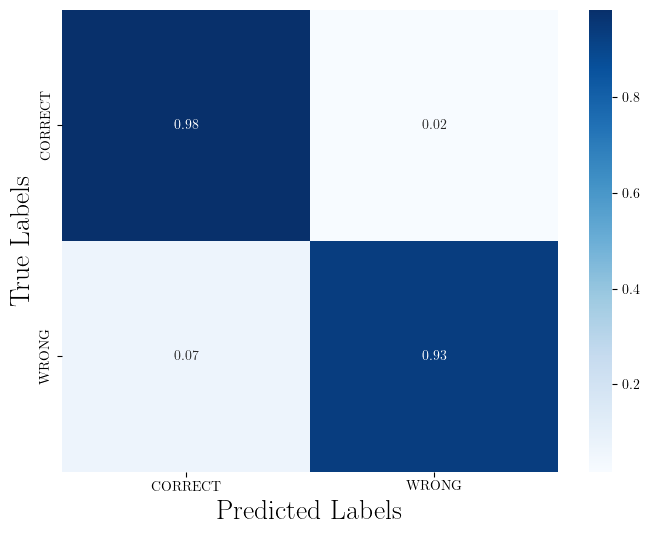

In [19]:
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='0.2f', cmap='Blues',
            xticklabels=['CORRECT', 'WRONG'],
            yticklabels=['CORRECT', 'WRONG'])
plt.xlabel('Predicted Labels', size=label_size)
plt.ylabel('True Labels', size=label_size)
if SAVE_FIGURES:
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'confusion-matrix_{BEST_MODEL}.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'confusion-matrix_{BEST_MODEL}.pdf'), dpi=300)
else:
    plt.title(f'Confusion Matrix for model:\n{renaming_rank_model_map[BEST_MODEL]}', size=16)
plt.show()


In [20]:

    
def get_group(row):
    _,row=row
    if row['human_tag'] and row['agree']:
        return "True Positive"
    if row['human_tag'] and not row['agree']:
        return "False Negative"
    if not row['human_tag'] and row['agree']:
        return "True Negative"
    if not row['human_tag'] and not row['agree']:
        return "False Positive"


plot_df = merged_df.loc[(merged_df["embedding_model"].str.contains(BEST_MODEL)) *\
                         (merged_df["enhance"]==BEST_IS_ENHANCED) *\
                         (merged_df["reranker"]==BEST_IS_RERANKER) *\
                         (merged_df["instruction_applied"]==BEST_IS_INSTRUCTED) ]

# plot_df = plot_df.loc[plot_df["task_type"]=="bAbI / open-ended"]



plot_df = plot_df.groupby(['agree', 'human_tag', "dataset_task", "task_type"]).agg(
        {
            'a-vert_correct_score' : 'mean',
            'a-vert_wrong_score' : 'mean',
        }
    ).reset_index()
plot_df['score_distance']=plot_df['a-vert_correct_score']-plot_df['a-vert_wrong_score']
plot_df['score_abs_distance']=np.abs(plot_df['score_distance'])
plot_df['group'] = [get_group(a) for a in plot_df.iterrows()]

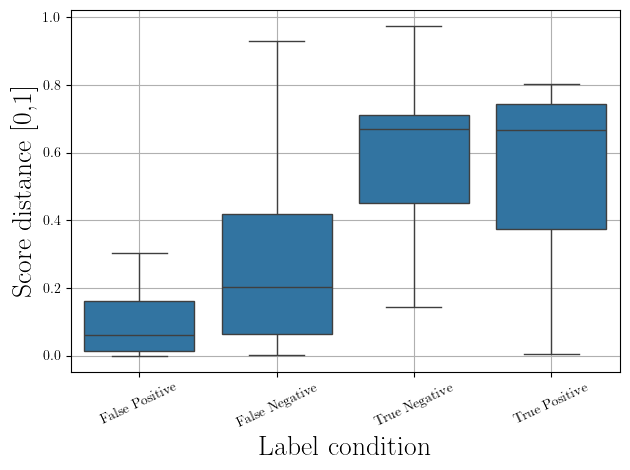

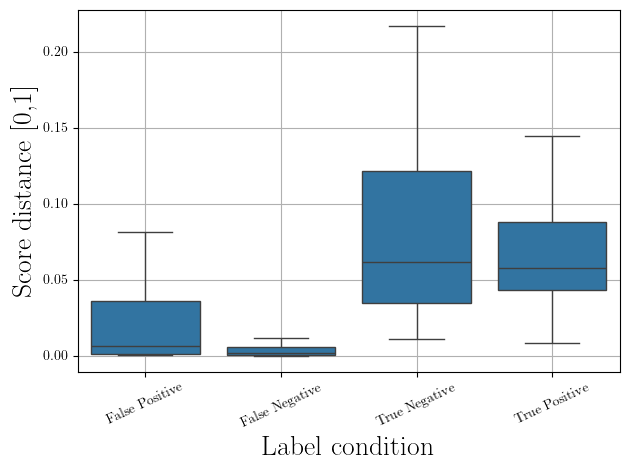

In [21]:
if not SAVE_FIGURES:
    plt.figure()  
for i, data_part in enumerate(["bAbI / open-ended", "MMLU / multiple-choice"]):
    plot_df2 = plot_df.loc[(plot_df["task_type"]==data_part)]
    # plot_df.boxplot(by='group', column =['score_distance'])
    if SAVE_FIGURES:
        plt.figure()  
        ax=plt.gca()
    else:
        ax=plt.subplot(1,2,i+1)
    sns.boxplot(data=plot_df2, x="group", y="score_abs_distance", ax=ax, showfliers=False)

    plt.grid()
    plt.xlabel("Label condition", size=label_size)
    plt.ylabel("Score distance [0,1]", size=label_size)
    plt.xticks(rotation=25)

    if SAVE_FIGURES:
        plt.draw()
        plt.tight_layout()
        if 'mmlu' in data_part.lower():
            plot_name = 'mmlu_dist_targets'
        else:
            plot_name = 'babi_dist_targets'
        plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'{plot_name}.png'))
        plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'{plot_name}.pdf'), dpi=300)
        plt.show()
    else:
        plt.title(data_part, size=title_size)


if not SAVE_FIGURES:
    plt.suptitle(f'Distance between scores for each result group\nModel:{BEST_MODEL}', size=title_size)
    plt.tight_layout()
    plt.show()



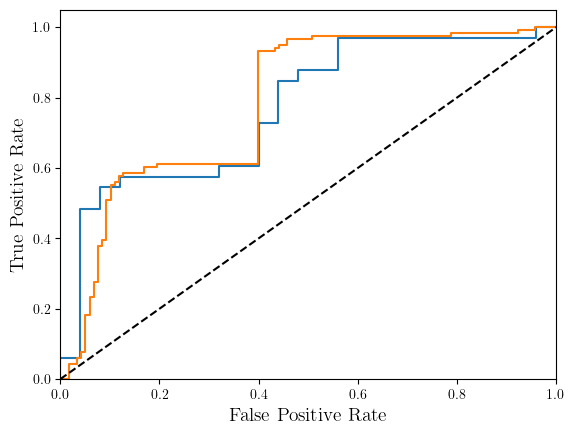

In [22]:
plt.figure()  
for data_part in ["bAbI / open-ended", "MMLU / multiple-choice"]:
    plot_df2 = plot_df.loc[(plot_df["task_type"]==data_part)]

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(plot_df2['human_tag'], plot_df2['a-vert_correct_score']) 
    roc_auc = auc(fpr, tpr)
    # Plot the ROC curve

    plt.plot(fpr, tpr, label=f'{data_part} (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)

if SAVE_FIGURES:
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'ROC_{BEST_MODEL}.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'ROC_{BEST_MODEL}.pdf'), dpi=300)
else:
    plt.title(data_part, size=16)
    plt.title('ROC Curve', size=16)
    plt.legend()
plt.show()

# Approximate Token Usage

This is a very rough approximation not including thinking tokens.

In [23]:
plot_df = data_df.loc[(data_df["embedding_model"].str.contains(BEST_MODEL)) *\
                         (data_df["enhance"]==BEST_IS_ENHANCED) *\
                         (data_df["reranker"]==BEST_IS_RERANKER) *\
                         (data_df["instruction_applied"]==BEST_IS_INSTRUCTED) ]

In [24]:
plot_df.groupby(['language_model']).agg({"aprox_input_tokens" : "sum", "aprox_output_tokens": "sum"})
df_melt = plot_df.melt(id_vars = 'language_model',
                  value_vars = ['aprox_input_tokens', 'aprox_output_tokens'],
                  var_name = 'columns')

# remap language_model values
df_melt['language_model'] = df_melt['language_model'].map(rename_llm_model_map)

In [25]:
df_melt

,language_model,columns,value
0,Meta-Llama-3-3-70B-Instruct,aprox_input_tokens,15
1,Meta-Llama-3-3-70B-Instruct,aprox_input_tokens,21
2,Meta-Llama-3-3-70B-Instruct,aprox_input_tokens,30
3,Meta-Llama-3-3-70B-Instruct,aprox_input_tokens,36
4,Meta-Llama-3-3-70B-Instruct,aprox_input_tokens,42
...,...,...,...
54595,gpt-oss-20b,aprox_output_tokens,87
54596,gpt-oss-20b,aprox_output_tokens,1
54597,gpt-oss-20b,aprox_output_tokens,9
54598,gpt-oss-20b,aprox_output_tokens,9


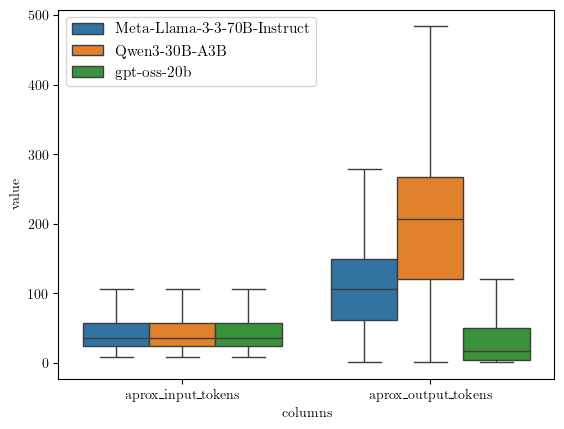

In [26]:

sns.boxplot(data = df_melt,
                hue = 'language_model', # different colors for different 'cls'
                x = 'columns',
                y = 'value',
                order = ['aprox_input_tokens', 'aprox_output_tokens'],
                showfliers=False,
                legend=True)

plt.legend(loc='best', prop={'size': 11})
plt.show()

# SemScore Analysis

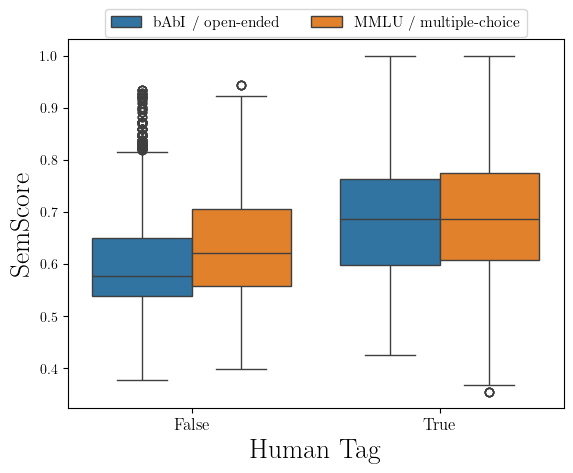

In [27]:
plt.figure()
# semscore_df = merged_df.loc[merged_df["embedding_model"].str.contains("Qwen3-Reranker-0.6B-seq-cls")] # This run calcualted semscore
semscore_df = merged_df.loc[(merged_df["semscore"] != 0)]
# semscore_df.boxplot(by='human_tag', column =['semscore'],)
# sns.violinplot(data=semscore_df, x="human_tag", y="semscore", hue="task_type")
sns.boxplot(data=semscore_df, x="human_tag", y="semscore", hue="task_type", legend=True)
# increase the ticks font size
plt.xticks(size=12)
plt.ylabel("SemScore", size=label_size)
plt.xlabel("Human Tag", size=label_size)

if SAVE_FIGURES:
    plt.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.10), prop={'size': 11})
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'semscore_boxplot.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'semscore_boxplot.pdf'), dpi=300, bbox_inches='tight')
else:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



In [28]:
# Calculate optimal threshold
opt_val = 0
thrs_opt = 0
for thrs in np.linspace(0.01,0.99,100):
    predicted_semscore = semscore_df['semscore'] > thrs
    opt = balanced_accuracy_score(semscore_df['human_tag'], predicted_semscore)
    if opt_val < opt:
        opt_val = opt
        thrs_opt = thrs
print(f"Optimal Threshold: {thrs_opt}\nBalanced Accuracy: {opt_val}")

Optimal Threshold: 0.6138383838383838
Balanced Accuracy: 0.6254541427417497


In [29]:
thrs = thrs_opt
predicted_semscore = semscore_df['semscore'] > thrs

# Calculate precision and recall
precision = precision_score(semscore_df['human_tag'], predicted_semscore)
recall = recall_score(semscore_df['human_tag'], predicted_semscore)
f1 = f1_score(semscore_df['human_tag'], predicted_semscore)
specificity = recall_score(1-semscore_df['human_tag'], 1-predicted_semscore)
balanced_accuracy = balanced_accuracy_score(semscore_df['human_tag'], predicted_semscore)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Specificity: {specificity:.2f}")
print(f"F1: {f1:.2f}")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}")

Precision: 0.88
Recall: 0.72
Specificity: 0.53
F1: 0.79
Balanced Accuracy: 0.63


# Baselines Comparisons

In [30]:
merged_to_compare_df = merged_df.loc[(merged_df["embedding_model"].str.contains(BEST_MODEL)) *\
                         (merged_df["enhance"]==BEST_IS_ENHANCED) *\
                         (merged_df["reranker"]==BEST_IS_RERANKER) *\
                         (merged_df["instruction_applied"]==BEST_IS_INSTRUCTED) ]
grouped_to_compare_df = merged_to_compare_df.groupby(['language_model',	'dataset_task']).agg(
        {
            'human_tag' : "mean", 
            'a-vert_match': "mean",
            'agree': "mean"
        }
    ).reset_index().sort_values("agree")
grouped_to_compare_df.head()
# remane language_model by using rename_llm_model_map
grouped_to_compare_df["language_model"] = grouped_to_compare_df["language_model"].map(rename_llm_model_map)


### MMLU-Pro --- Completions + Logits

In [31]:
logits_rows = list()
for lm_dir in os.listdir(BASELINES_PATH):
    model_path = os.path.join(BASELINES_PATH, lm_dir)
    if not os.path.isdir(model_path):
        continue
    # The file should be here
    for results_file in os.listdir(os.path.join(BASELINES_PATH, lm_dir, "mmlu_pro_categories")):
        if "results_" not in results_file:
            continue
        # Read all lines
        with open(os.path.join(BASELINES_PATH, lm_dir, "mmlu_pro_categories", results_file), 'r') as f:
            obj = json.load(f)
            for key in obj["results"].keys():
                if "mmlu_pro-category-leaderboard" in key:
                    logits_rows.append([
                        lm_dir,
                        "mmlu_pro-category"+key.split("mmlu_pro-category-leaderboard")[-1],
                        obj["results"][key]["acc,none"]
                    ])

logits_df = pd.DataFrame(logits_rows, columns=["language_model", "dataset_task", "acc_score"])
# rename language_model by using rename_llm_model_map
logits_df["language_model"] = logits_df["language_model"].map(rename_llm_model_map)

merged_logits_df = pd.merge(logits_df, grouped_to_compare_df, on=['language_model', 'dataset_task'])

In [32]:
plt_df = deepcopy(merged_logits_df)
plt_df["Logits Score"] = plt_df["acc_score"]
plt_df["Human Tag"] = plt_df["human_tag"]
plt_df["A-VERT"] = plt_df["a-vert_match"]

df_melt = plt_df.melt(id_vars = 'language_model',
                  value_vars = ['Logits Score', 'Human Tag', 'A-VERT'],
                  var_name = 'columns')

/tmp/ipykernel_457129/3998513227.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), size=label_size)


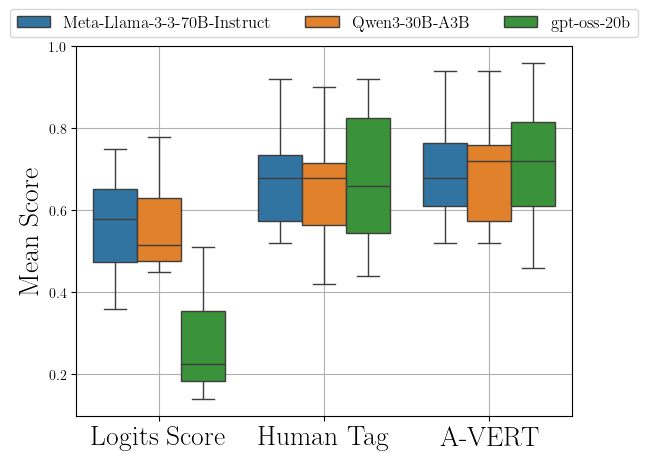

In [33]:
g = sns.boxplot(data = df_melt,
                hue = 'language_model', # different colors for different 'cls'
                x = 'columns',
                y = 'value',
                order = ['Logits Score', 'Human Tag', 'A-VERT'],
                legend=True )
# increase the ticks font size
g.set_xticklabels(g.get_xticklabels(), size=label_size)
plt.grid()

plt.xlabel("")
plt.ylabel("Mean Score", size=label_size)

if SAVE_FIGURES:
    plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', borderaxespad=0., ncol=3,
                prop={'size': 12})
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu-pro_comparison.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu-pro_comparison.pdf'), dpi=300, bbox_inches='tight')
else:
    plt.title('Comparison of MMLU-Pro Scores\nfor the first 100 questions using different metrics.')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [34]:
plot_df = merged_logits_df.loc[merged_logits_df["language_model"] != "gpt-oss-20b"]
# plot_df = merged_logits_df.loc[merged_logits_df["language_model"] == "Meta-Llama-3-3-70B-Instruct-AWQ-INT4"]
# plot_df = merged_logits_df.loc[merged_logits_df["language_model"] == "Qwen3-30B-A3B-GPTQ-Int4"]

plot_df = plot_df.melt(id_vars = ['dataset_task', "language_model"],
                  value_vars = ['acc_score', 'human_tag', 'a-vert_match'],
                  var_name = 'scorer')
plot_df = plot_df.groupby(["scorer", "dataset_task"]).agg({"value":"mean"}).reset_index()
plot_df = plot_df.sort_values("value",ascending=True)
plot_df["dataset_task"] = [a.split("mmlu_pro-category_")[-1] for a in plot_df["dataset_task"].values]
plot_df.head()

# plot_df["value"] += np.random.normal(0, 0.01, len(plot_df))

# rename 'acc_score` as 'Excact match' in scorer
mapping = {
    'acc_score': 'Logits Score',
    'human_tag': 'Human Tag',
    'a-vert_match': 'A-VERT'
}
plot_df['scorer'] = plot_df['scorer'].map(mapping)

In [35]:
logits_regression = deepcopy(plot_df)
logits_regression

,scorer,dataset_task,value
19,Logits Score,engineering,0.415
16,Logits Score,chemistry,0.440
15,Logits Score,business,0.470
26,Logits Score,physics,0.480
33,Human Tag,engineering,0.480
23,Logits Score,math,0.485
24,Logits Score,other,0.510
35,Human Tag,history,0.520
8,A-VERT,law,0.530
36,Human Tag,law,0.530


/tmp/ipykernel_457129/3458097727.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  scatter.set_xticklabels(scatter.get_xticklabels(), size=label_size)


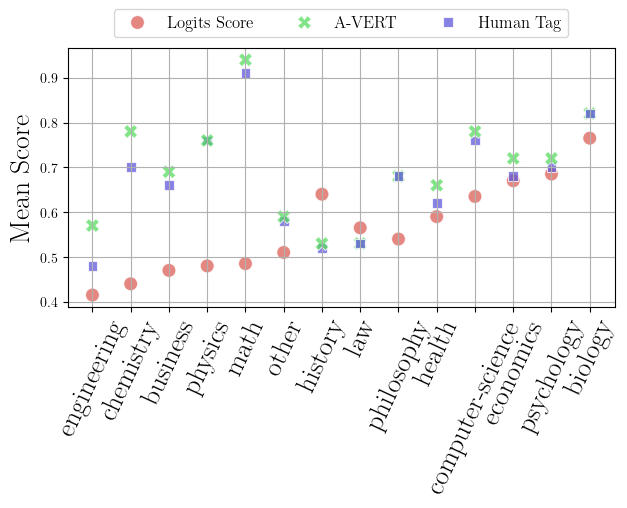

In [36]:
scatter = sns.scatterplot(data=plot_df, 
                          x="dataset_task",
                          y="value", 
                          hue='scorer', 
                          hue_order=['Logits Score', 'A-VERT', 'Human Tag'], 
                          style='scorer', 
                          style_order=['Logits Score', 'A-VERT', 'Human Tag'], 
                          s=100,
                          palette="hls", alpha=0.75,
                          legend=True
                          )
# pltylim(0.5,1.0)
plt.grid()
scatter.set_xticklabels(scatter.get_xticklabels(), size=label_size)
plt.xlabel("", size=label_size)
plt.ylabel("Mean Score", size=label_size)
plt.xticks(rotation=65)
plt.tight_layout()

if SAVE_FIGURES:
    plt.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', borderaxespad=0., ncol=3,fontsize=12)
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu-pro_comp_task.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu-pro_comp_task.pdf'), dpi=300, bbox_inches='tight')
else:
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Comparison of MMLU-Pro by-task scores\nfor the first 100 questions using different metrics.')

plt.show()

### bAbI --- Completions + Exact-Match

In [37]:
logits_rows = list()
for lm_dir in os.listdir(BASELINES_PATH):
    model_path = os.path.join(BASELINES_PATH, lm_dir)
    if not os.path.isdir(model_path):
        continue
    # The file should be here
    for results_file in os.listdir(os.path.join(BASELINES_PATH, lm_dir, "babi_tasks")):
        if "results_" not in results_file:
            continue
        # Read all lines
        with open(os.path.join(BASELINES_PATH, lm_dir, "babi_tasks", results_file), 'r') as f:
            obj = json.load(f)
            for key in obj["results"].keys():
                if "babi_tasks_completions" in key:
                    logits_rows.append([
                        lm_dir,
                        "babi-task_"+key.split("babi_tasks_completions-task_")[-1],
                        obj["results"][key]["exact_match,get_response"]
                    ])

babi_base_df = pd.DataFrame(logits_rows, columns=["language_model", "dataset_task", "exact_match"])
# rename language_model by using rename_llm_model_map
babi_base_df["language_model"] = babi_base_df["language_model"].map(rename_llm_model_map)
merged_babi_base_df = pd.merge(babi_base_df, grouped_to_compare_df, on=['language_model', 'dataset_task'])


In [38]:
plt_df = deepcopy(merged_babi_base_df)
plt_df["Exact Match"] = plt_df["exact_match"]
plt_df["Human Tag"] = plt_df["human_tag"]
plt_df["A-VERT"] = plt_df["a-vert_match"]

df_melt = plt_df.melt(id_vars = 'language_model',
                  value_vars = ['Exact Match', 'Human Tag', 'A-VERT'],
                  var_name = 'columns')

In [39]:
df_melt

,language_model,columns,value
0,Meta-Llama-3-3-70B-Instruct,Exact Match,1.00
1,Meta-Llama-3-3-70B-Instruct,Exact Match,0.88
2,Meta-Llama-3-3-70B-Instruct,Exact Match,0.56
3,Meta-Llama-3-3-70B-Instruct,Exact Match,0.97
4,Meta-Llama-3-3-70B-Instruct,Exact Match,0.94
...,...,...,...
175,gpt-oss-20b,A-VERT,0.04
176,gpt-oss-20b,A-VERT,0.20
177,gpt-oss-20b,A-VERT,1.00
178,gpt-oss-20b,A-VERT,0.98


/tmp/ipykernel_457129/842315977.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), size=14)


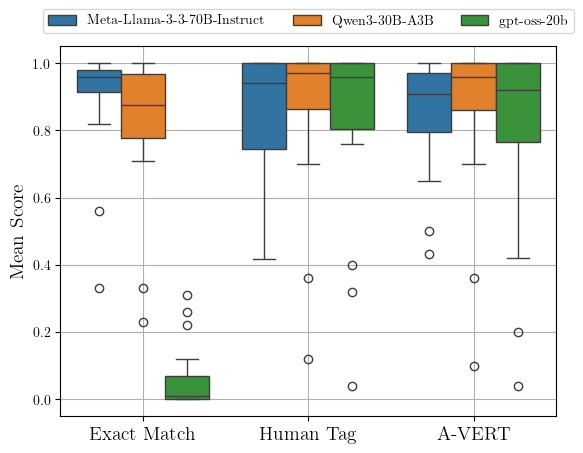

In [40]:
g = sns.boxplot(data = df_melt,
                hue = 'language_model', # different colors for different 'cls'
                x = 'columns',
                y = 'value',
                order = ['Exact Match', 'Human Tag', 'A-VERT'],
                legend=SAVE_FIGURES
                   )
g.set_xticklabels(g.get_xticklabels(), size=14)
plt.grid()
plt.xlabel("")
plt.ylabel("Mean Score", size=14)

if SAVE_FIGURES:
    plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', borderaxespad=0., ncol=3)
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'babi_comparison.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'babi_comparison.pdf'), dpi=300, bbox_inches='tight')
else:
    plt.title('Comparison of bAbI Scores\nfor the first 100 questions using different metrics.')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [41]:
plot_df = merged_babi_base_df.loc[merged_babi_base_df["language_model"] != "gpt-oss-20b"]
# plot_df = merged_babi_base_df.loc[merged_babi_base_df["language_model"] == "Meta-Llama-3-3-70B-Instruct-AWQ-INT4"]
# plot_df = merged_babi_base_df.loc[merged_babi_base_df["language_model"] == "Qwen3-30B-A3B-GPTQ-Int4"]


plot_df = plot_df.melt(id_vars = ['dataset_task', "language_model"],
                  value_vars = ['exact_match', 'human_tag', 'a-vert_match'],
                  var_name = 'scorer')
plot_df = plot_df.groupby(["scorer", "dataset_task"]).agg({"value":"mean"}).reset_index()
plot_df = plot_df.sort_values("value",ascending=True)
if not SAVE_FIGURES:
  plot_df["dataset_task"] = [a.split("babi-task_")[-1] for a in plot_df["dataset_task"].values]
else:
  plot_df["dataset_task"] = [a.split("babi-task_")[-1].split("-")[0] for a in plot_df["dataset_task"].values]

In [42]:
mapping = {
    'exact_match': 'Exact Match',
    'human_tag': 'Human Tag',
    'a-vert_match': 'A-VERT'
}
plot_df['scorer'] = plot_df['scorer'].map(mapping)

In [43]:
plot_df

,scorer,dataset_task,value
15,A-VERT,16,0.266667
55,Human Tag,16,0.268333
38,Exact Match,19,0.280000
2,A-VERT,03,0.430000
42,Human Tag,03,0.430000
22,Exact Match,03,0.445000
59,Human Tag,20,0.716667
56,Human Tag,17,0.741667
18,A-VERT,19,0.765000
1,A-VERT,02,0.765000


In [44]:
exact_match_regression = deepcopy(plot_df)

/tmp/ipykernel_457129/2235685950.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  scatter.set_xticklabels(new_xticks, size=12)


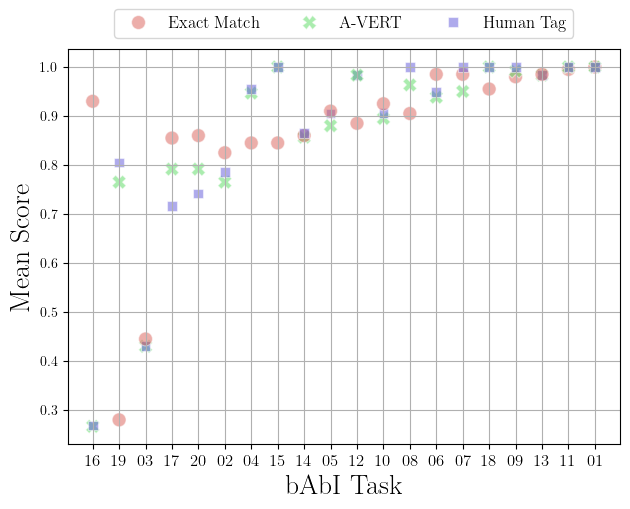

In [45]:
scatter = sns.scatterplot(data=plot_df, 
                          x="dataset_task",
                          y="value", 
                          hue='scorer', 
                          hue_order=['Exact Match', 'A-VERT', 'Human Tag'], 
                          style='scorer', 
                          style_order=['Exact Match', 'A-VERT', 'Human Tag'], 
                          s=100,
                          palette="hls", alpha=0.5,
                          legend=True
                          )
# pltylim(0.5,1.0)
new_xticks = [
"16",
"19",
"03",
"17",
"20",
"02",
"04",
"15",
"14",
"05",
"12",
"10",
"08",
"06",
"07",
"18",
"09",
"13",
"11",
"01"
]
scatter.set_xticklabels(new_xticks, size=12)
plt.grid()
plt.xlabel("bAbI Task", size=label_size)
plt.ylabel("Mean Score", size=label_size)
plt.tight_layout()

if SAVE_FIGURES:
    plt.legend(bbox_to_anchor=(0.5, 1.10), loc='upper center', borderaxespad=0., ncol=3,fontsize=12)
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'babi_comp_task.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'babi_comp_task.pdf'), dpi=300, bbox_inches='tight')
else:
    plt.title('Comparison of bAbI Scores by-task\nfor the first 100 questions using different metrics.')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    #plt.xticks(rotation=90)
    
plt.show()

### MMLU --- Chat-Completions + Exact-Match

In [46]:
logits_rows = list()
for lm_dir in os.listdir(BASELINES_PATH):
    model_path = os.path.join(BASELINES_PATH, lm_dir)
    if not os.path.isdir(model_path):
        continue
    # The file should be here
    for results_file in os.listdir(os.path.join(BASELINES_PATH, lm_dir, "mmlu_generative")):
        if "results_" not in results_file:
            continue
        # Read all lines
        with open(os.path.join(BASELINES_PATH, lm_dir, "mmlu_generative", results_file), 'r') as f:
            obj = json.load(f)
            for key in obj["results"].keys():
                if "mmlu_" in key:
                    logits_rows.append([
                        lm_dir,
                        "mmlu_"+key.split("mmlu_")[-1].split("_generative")[0]+ "_chat_generative",
                        obj["results"][key]["exact_match,get_response"]
                    ])

mmlu_base_df = pd.DataFrame(logits_rows, columns=["language_model", "dataset_task", "exact_match"])
# rename language_model by using rename_llm_model_map
mmlu_base_df["language_model"] = mmlu_base_df["language_model"].map(rename_llm_model_map)

merged_mmlu_base_df = pd.merge(mmlu_base_df, grouped_to_compare_df, on=['language_model', 'dataset_task'])


In [47]:
plt_df = deepcopy(merged_mmlu_base_df)
plt_df["Exact Match"] = plt_df["exact_match"]
plt_df["Human Tag"] = plt_df["human_tag"]
plt_df["A-VERT"] = plt_df["a-vert_match"]

df_melt = plt_df.melt(id_vars = 'language_model',
                  value_vars = ['Exact Match', 'Human Tag', 'A-VERT'],
                  var_name = 'columns')

/tmp/ipykernel_457129/2163180875.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), size=label_size*0.9)


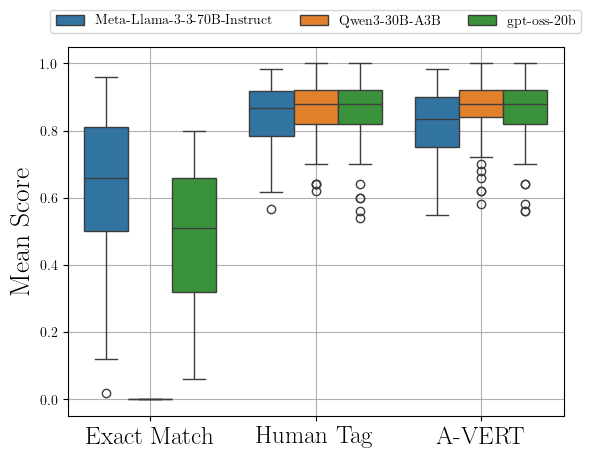

In [48]:
g = sns.boxplot(data = df_melt,
                hue = 'language_model', # different colors for different 'cls'
                x = 'columns',
                y = 'value',
                order = ['Exact Match', 'Human Tag', 'A-VERT'],
                legend=True
                   )

g.set_xticklabels(g.get_xticklabels(), size=label_size*0.9)
plt.grid()

plt.xlabel("")
plt.ylabel("Mean Score", size=label_size)

if SAVE_FIGURES:
    plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', borderaxespad=0., ncol=3)
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_comparison.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_comparison.pdf'), dpi=300, bbox_inches='tight')
else:
    plt.title('Comparison of MMLU Scores\nfor the first 100 questions using different metrics.')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [49]:
plot_df = merged_mmlu_base_df.loc[merged_mmlu_base_df["language_model"] != "Qwen3-30B-A3B"]
# plot_df = merged_babi_base_df.loc[merged_babi_base_df["language_model"] == "Meta-Llama-3-3-70B-Instruct"]
# plot_df = merged_babi_base_df.loc[merged_babi_base_df["language_model"] == "gpt-oss-20b"]


plot_df = plot_df.melt(id_vars = ['dataset_task', "language_model"],
                  value_vars = ['exact_match', 'human_tag', 'a-vert_match'],
                  var_name = 'scorer')
plot_df = plot_df.groupby(["scorer", "dataset_task"]).agg({"value":"mean"}).reset_index()
plot_df = plot_df.sort_values("value",ascending=True)
plot_df["dataset_task"] = [a.split("mmlu_")[-1].split("_chat_generative")[0] for a in plot_df["dataset_task"].values]
plot_df.head()

,scorer,dataset_task,value
74,exact_match,global_facts,0.135
112,exact_match,virology,0.185
84,exact_match,high_school_physics,0.230
82,exact_match,high_school_mathematics,0.230
63,exact_match,college_chemistry,0.250


In [50]:
mapping = {
    'exact_match': 'Exact Match',
    'human_tag': 'Human Tag',
    'a-vert_match': 'A-VERT'
}
plot_df['scorer'] = plot_df['scorer'].map(mapping)

In [51]:
exact_match_regression = pd.concat([exact_match_regression, plot_df])

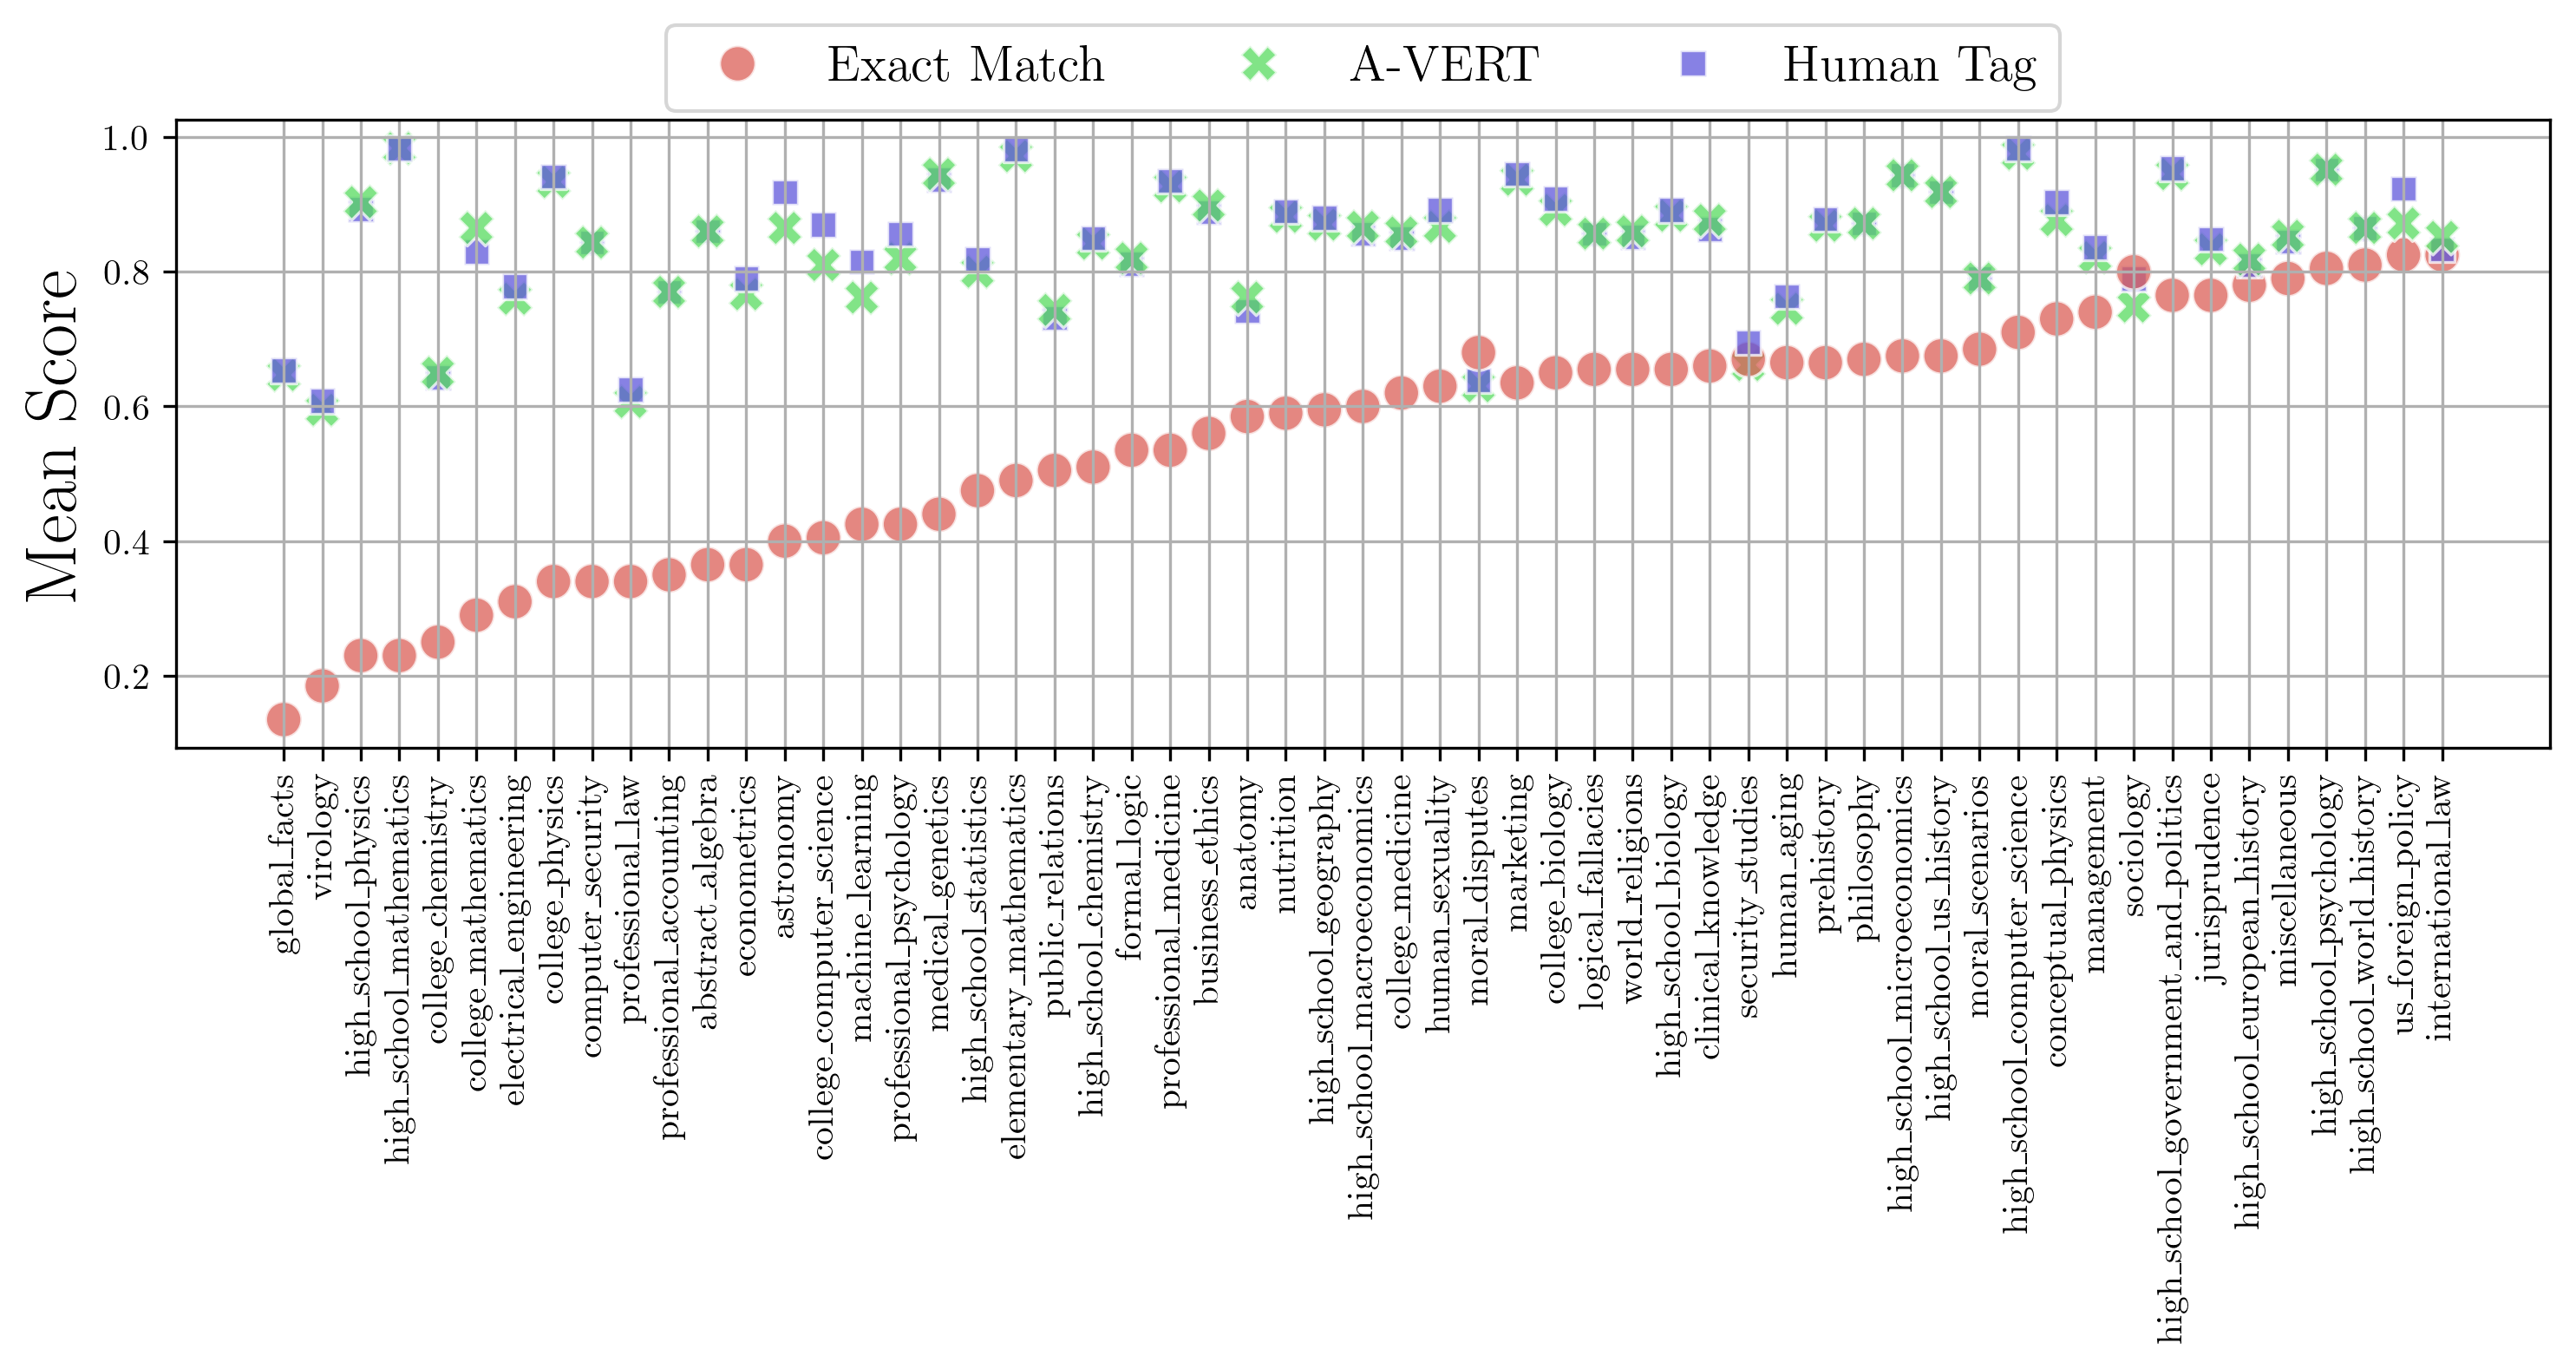

In [52]:
plt.figure(figsize=(10, 5), dpi=300)
scatter = sns.scatterplot(data=plot_df, 
                          x="dataset_task",
                          y="value", 
                          hue='scorer', 
                          hue_order=['Exact Match', 'A-VERT', 'Human Tag'], 
                          style='scorer', 
                          style_order=['Exact Match', 'A-VERT', 'Human Tag'], 
                          s=100,
                          palette="hls", alpha=0.75,
                          legend=True
                          )
# pltylim(0.5,1.0)
plt.grid()
plt.xlabel("", size=label_size)
plt.ylabel("Mean Score", size=label_size)
plt.xticks(rotation=90)
plt.tight_layout()

if SAVE_FIGURES:
    #plt.legend(loc='upper right', borderaxespad=0., ncol=1, fontsize=12, bbox_to_anchor=(1.2, 1))
    plt.legend(bbox_to_anchor=(0.5, 1.15), loc='upper center', borderaxespad=0., ncol=3,fontsize=14)
    plt.draw()
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_comp_task.png'))
    plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_comp_task.pdf'), dpi=300, bbox_inches='tight')
else:
    plt.title('Comparison of MMLU Scores by-task\nfor the first 100 questions using different metrics.')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  
plt.show()

In [ ]:
def result_plot(y_test, y_pred, lim_pred, color='b', marker='s', score='A-VERT'):
    from sklearn import linear_model
    from sklearn.metrics import r2_score

    regr = linear_model.LinearRegression()
    regr.fit(y_test.reshape(-1,1), y_pred.reshape(-1,1))
    r2 = np.round(r2_score(y_true=y_test.reshape(-1,1),y_pred=y_pred.reshape(-1,1)),3)
    print('R2_{}: {:.3f}'.format(score,r2,))

    lin_x_pred = np.arange(2*lim_pred[0], lim_pred[1]*2, dtype=float)
    lin_y_pred = regr.predict(lin_x_pred.reshape(-1,1))
    
    f, ax = plt.subplots()
    # Identity (at the back, z=0)
    ax.plot([-1, 2], [-1, 2], color='r', label='Identity', linewidth=2, zorder=0)
    # Scatter
    ax.scatter(y_test, y_pred,c=color,marker=marker,label=score,alpha=0.5, zorder=5)
    # Linear regression
    ax.plot(lin_x_pred, lin_y_pred, color='k',label='R2={}'.format(r2), linewidth=1, linestyle='--', zorder=10)

    ax.set_xlabel('Human Tag', fontsize=label_size)
    ax.set_ylabel(score+' score', fontsize=label_size)
    #ax.set_title('Sub-tasks comparison',fontsize=24)
    # legend
    ax.legend(loc='upper left', fontsize=12)
    # add grid
    ax.grid(True)
    plt.xlim(lim_pred)
    plt.ylim(lim_pred)

    return(f, ax)

# Regression Analysis
## Exact-Match vs A-VERT

In [54]:
pivot_df_em = pd.pivot_table(exact_match_regression, index='dataset_task', columns='scorer', values='value')
pivot_df_em.reset_index(inplace=True)
pivot_df_em

scorer,dataset_task,A-VERT,Exact Match,Human Tag
0,01,1.000000,1.000,1.000000
1,02,0.765000,0.825,0.785000
2,03,0.430000,0.445,0.430000
3,04,0.946667,0.845,0.955000
4,05,0.880000,0.910,0.905000
...,...,...,...,...
72,security_studies,0.661667,0.670,0.695000
73,sociology,0.748333,0.800,0.790000
74,us_foreign_policy,0.871667,0.825,0.923333
75,virology,0.595000,0.185,0.608333


R2_A-VERT: 0.968


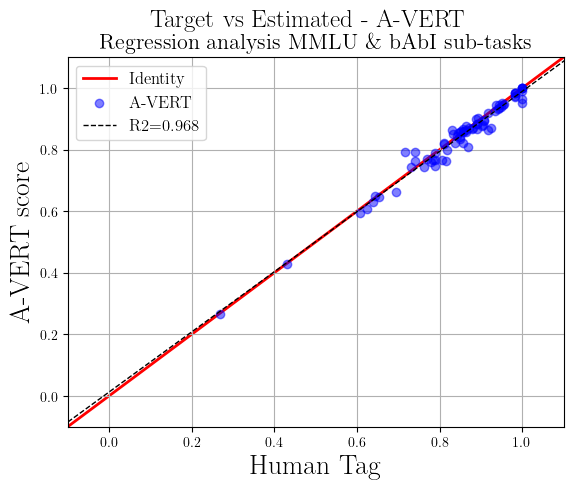

R2_Exact Match: -4.912


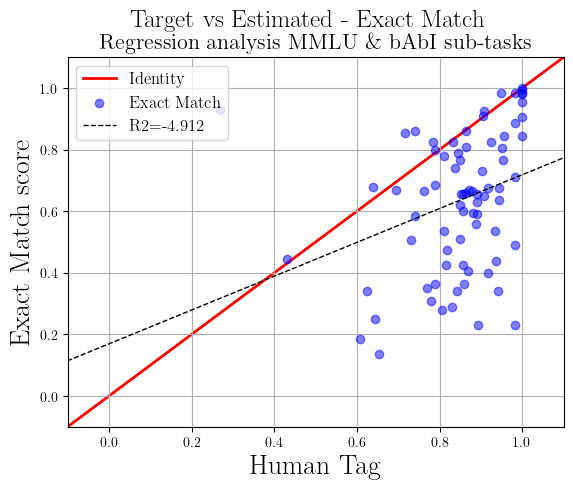

In [55]:
f, ax = result_plot(
    y_test=pivot_df_em["Human Tag"].values,
    y_pred=pivot_df_em["A-VERT"].values,
    lim_pred=[-0.1,1.1],
    color='b',
    marker='o',
    score='A-VERT')

ax.set_title('Regression analysis MMLU \\& bAbI sub-tasks', fontsize=16)
f.suptitle('Target vs Estimated - A-VERT', fontsize=18)
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_babi_regression_avert.png'))
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_babi_regression_avert.pdf'), bbox_inches='tight')
plt.show()

f, ax = result_plot(
    y_test=pivot_df_em["Human Tag"].values,
    y_pred=pivot_df_em["Exact Match"].values,
    lim_pred=[-0.1,1.1],
    color='b',
    marker='o',
    score='Exact Match')
ax.set_title('Regression analysis MMLU \\& bAbI sub-tasks', fontsize=16)
f.suptitle('Target vs Estimated - Exact Match', fontsize=18)
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_babi_regression_exactmatch.png'))
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_babi_regression_exactmatch.pdf'), bbox_inches='tight')
plt.show()

## Logits Score vs A-VERT

In [56]:
pivot_df_ls = pd.pivot_table(logits_regression, index='dataset_task', columns='scorer', values='value')
pivot_df_ls.reset_index(inplace=True)
pivot_df_ls

scorer,dataset_task,A-VERT,Human Tag,Logits Score
0,biology,0.82,0.82,0.765
1,business,0.69,0.66,0.470
2,chemistry,0.78,0.70,0.440
3,computer-science,0.78,0.76,0.635
4,economics,0.72,0.68,0.670
5,engineering,0.57,0.48,0.415
6,health,0.66,0.62,0.590
7,history,0.53,0.52,0.640
8,law,0.53,0.53,0.565
9,math,0.94,0.91,0.485


R2_A-VERT: 0.890


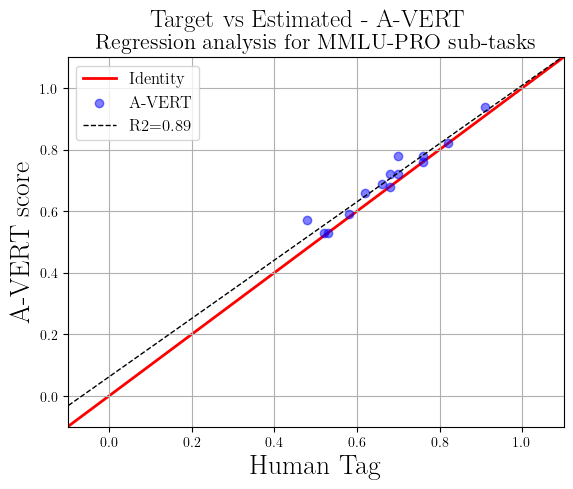

R2_Logits Score: -1.281


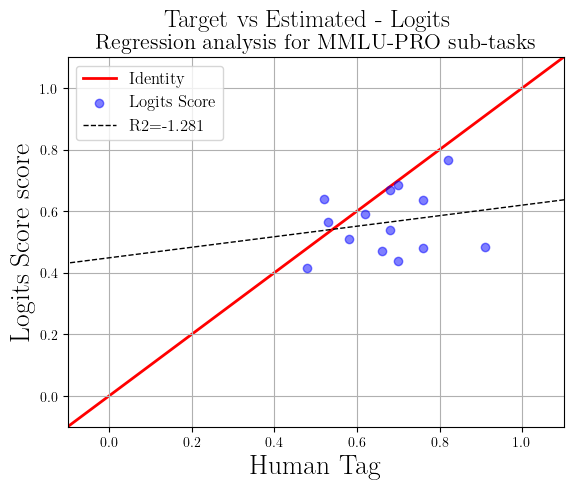

In [57]:
f, ax = result_plot(
    y_test=pivot_df_ls["Human Tag"].values,
    y_pred=pivot_df_ls["A-VERT"].values,
    lim_pred=[-0.1,1.1],
    color='b',
    marker='o',
    score='A-VERT')
ax.set_title('Regression analysis for MMLU-PRO sub-tasks', fontsize=16)
f.suptitle('Target vs Estimated - A-VERT', fontsize=18)
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_pro_regression_avert.png'))
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_pro_regression_avert.pdf'), dpi=300, bbox_inches='tight')
plt.show()


f, ax = result_plot(
    y_test=pivot_df_ls["Human Tag"].values,
    y_pred=pivot_df_ls["Logits Score"].values,
    lim_pred=[-0.1,1.1],
    color='b',
    marker='o',
    score='Logits Score')
ax.set_title('Regression analysis for MMLU-PRO sub-tasks', fontsize=16)
f.suptitle('Target vs Estimated - Logits', fontsize=18)
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_pro_regression_logits.png'))
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'mmlu_pro_regression_logits.pdf'), dpi=300, bbox_inches='tight')
plt.show()

In [58]:
pivot_df_ls

scorer,dataset_task,A-VERT,Human Tag,Logits Score
0,biology,0.82,0.82,0.765
1,business,0.69,0.66,0.470
2,chemistry,0.78,0.70,0.440
3,computer-science,0.78,0.76,0.635
4,economics,0.72,0.68,0.670
5,engineering,0.57,0.48,0.415
6,health,0.66,0.62,0.590
7,history,0.53,0.52,0.640
8,law,0.53,0.53,0.565
9,math,0.94,0.91,0.485


# Overall Regression Analysis

In [59]:
# concatenate A-VERT and Human Tag columns
overall_comparison_df = pd.concat([
    pivot_df_em[['dataset_task', 'A-VERT', 'Human Tag']],
    pivot_df_ls[['dataset_task', 'A-VERT', 'Human Tag']]
], axis=0)

R2_A-VERT: 0.967


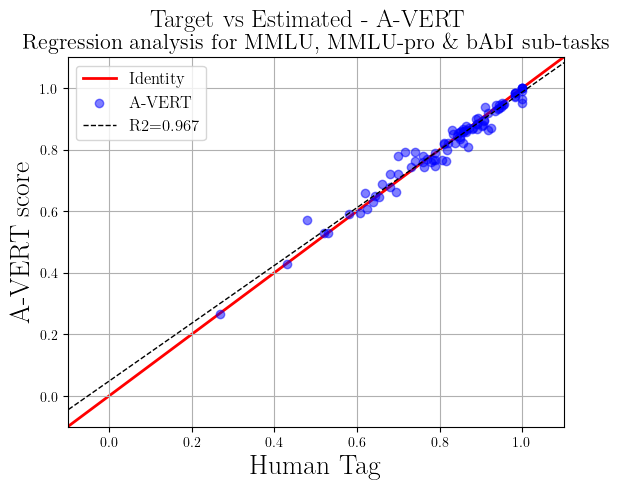

In [60]:
f, ax = result_plot(
    y_test=overall_comparison_df["Human Tag"].values,
    y_pred=overall_comparison_df["A-VERT"].values,
    lim_pred=[-0.1,1.1],
    color='b',
    marker='o',
    score='A-VERT')
ax.set_title('Regression analysis for MMLU, MMLU-pro \\& bAbI sub-tasks', fontsize=16)
f.suptitle('Target vs Estimated - A-VERT', fontsize=18)
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'overall_regression_avert.png'))
plt.savefig(os.path.join(OUTPUT_PATH_FIGURES, f'overall_regression_avert.pdf'), dpi=300, bbox_inches='tight')
plt.show()